In [1]:
import os
import sys
import copy
import pickle
import h5py
import numpy as np
from scipy import spatial
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from dragonfly import maximise_function
from style_transfer import transfer_style

Using TensorFlow backend.
/home/ktran/miniconda3/envs/art/lib/python2.7/site-packages/dragonfly/utils/oper_utils.py:30: UserWarning: cannot import name direct
Could not import Fortran direct library. Dragonfly can still be used, but might be slightly slower. To get rid of this warning, install a numpy compatible Fortran compiler (e.g. gfortran) and the python-dev package and reinstall Dragonfly.
  warn('%s\n%s'%(e, fortran_err_msg))


# Initialize
Load the information and models we need

In [2]:
art_folder = '../art_images/'

# Load the classifier
classifier = load_model('../sentiment_classification/resnet50_vso.h5')

# Initialize a dummy data generator so we can get our attribute labeling map
dummy_datagen = ImageDataGenerator()
dummy_gen = dummy_datagen.flow_from_directory('../sentiment_classification/train/',
                                              class_mode='categorical')
attr_map = dummy_gen.class_indices
attr_map

Instructions for updating:
Colocations handled automatically by placer.
Found 336072 images belonging to 260 classes.


{'abandoned': 0,
 'abused': 1,
 'adorable': 2,
 'adventurous': 3,
 'aggressive': 4,
 'amazing': 5,
 'amused': 6,
 'ancient': 7,
 'angry': 8,
 'annoying': 9,
 'anxious': 10,
 'appealing': 11,
 'arrested': 12,
 'arrogant': 13,
 'attractive': 14,
 'awesome': 15,
 'awful': 16,
 'bad': 17,
 'barking': 18,
 'beautiful': 19,
 'bitter': 20,
 'bloody': 21,
 'brave': 22,
 'bright': 23,
 'broken': 24,
 'bumpy': 25,
 'busy': 26,
 'calm': 27,
 'candid': 28,
 'charming': 29,
 'cheerful': 30,
 'christian': 31,
 'chubby': 32,
 'classic': 33,
 'clean': 34,
 'clear': 35,
 'clever': 36,
 'cloudy': 37,
 'cold': 38,
 'colorful': 39,
 'comfortable': 40,
 'concerned': 41,
 'confused': 42,
 'contagious': 43,
 'crazy': 44,
 'creepy': 45,
 'crooked': 46,
 'crowded': 47,
 'cruel': 48,
 'crying': 49,
 'cuddly': 50,
 'curious': 51,
 'cute': 52,
 'damaged': 53,
 'dangerous': 54,
 'dark': 55,
 'dead': 56,
 'deadly': 57,
 'deafening': 58,
 'delicious': 59,
 'delightful': 60,
 'derelict': 61,
 'determined': 62,
 'diff

Define some helper functions

In [3]:
def calc_attribute_match(encoded_feature_vector, attribute):
    # Perform style transfer
    update_style(encoded_feature_vector)
    
    # Use ResNet to classify the current image after style transfer
    global current_image
    probs = predict_adj_matches(current_image)

    # Return the match between the current image and the target attribute
    match = obj_fun(probs, attribute)
    return match


def update_style(encoded_feature_vector):
    # Increment the counter for specifying which folder to save the images in
    global updates
    results_folder = './style_transfer_%03d' % updates
    updates += 1
    # Make the directory to store the style transfer progression (EAFP)
    try:
        os.mkdir(results_folder)
    except OSError:
        pass

    # Fetch various information that we'll be using
    global current_image

    # Find the closest image to the vector provided, then transfer its style
    global tree
    global wga_names
    _, image_index = tree.query(encoded_feature_vector)
    style_image = wga_names[image_index]
    style_path = art_folder + 'images/' + style_image
    current_image = transfer_style(current_image, style_path,
                                   result_folder=results_folder)

    # Update the list of style images we've been using
    global style_images
    style_images.append(style_image)

    # Remove the style image from the list of candidates (to avoid redos)
    del wga_names[image_index]
    global encoded_features
    encoded_features = np.delete(encoded_features, image_index, axis=0)

    # Update some global variables
    global style_images
    style_images.append(style_image)
    tree = spatial.KDTree(encoded_features)


def predict_adj_matches(img_path):
    # Pull the image
    img = image.load_img(img_path, target_size=(128, 128))

    # Standardize/preprocess the image
    array = image.img_to_array(img)
    array -= np.mean(array, axis=2, keepdims=True)
    array /= (np.std(array, axis=2, keepdims=True) + 1e-7)
    array_expanded = np.expand_dims(array, axis=0)
    
    # Feed the image to our trained ResNet model
    probabilities = classifier.predict(array_expanded)[0, :]
    return probabilities


def obj_fun(probs, attribute):
    attr_index = attr_map[attribute]
    match = probs[attr_index]
    return match

<ipython-input-3-126317cac2c1>:47: SyntaxWarning: name 'style_images' is used prior to global declaration
  global style_images


# Spiral out

Optimisation with bo(ei-ucb-ttei-ts-add_ucb) using capital 2.0 (return_value)
Start of iteration 0
Current loss value:  36713496576.000000
Image saved as ./style_transfer_000/000.png
Iteration 0 completed in 4s
Start of iteration 1
Current loss value:  21094342656.000000
Image saved as ./style_transfer_000/001.png
Iteration 1 completed in 2s
Start of iteration 2
Current loss value:  17333727232.000000
Image saved as ./style_transfer_000/002.png
Iteration 2 completed in 2s
Start of iteration 3
Current loss value:  15964829696.000000
Image saved as ./style_transfer_000/003.png
Iteration 3 completed in 2s
Start of iteration 4
Current loss value:  15070263296.000000
Image saved as ./style_transfer_000/004.png
Iteration 4 completed in 2s
Start of iteration 5
Current loss value:  14499730432.000000
Image saved as ./style_transfer_000/005.png
Iteration 5 completed in 2s
Start of iteration 6
Current loss value:  14068090880.000000
Image saved as ./style_transfer_000/006.png
Iteration 6 complet

Start of iteration 0
Current loss value:  1277401088.000000
Image saved as ./style_transfer_003/000.png
Iteration 0 completed in 2s
Start of iteration 1
Current loss value:  704807808.000000
Image saved as ./style_transfer_003/001.png
Iteration 1 completed in 2s
Start of iteration 2
Current loss value:  560042240.000000
Image saved as ./style_transfer_003/002.png
Iteration 2 completed in 2s
Start of iteration 3
Current loss value:  501534016.000000
Image saved as ./style_transfer_003/003.png
Iteration 3 completed in 2s
Start of iteration 4
Current loss value:  471396352.000000
Image saved as ./style_transfer_003/004.png
Iteration 4 completed in 2s
Start of iteration 5
Current loss value:  451487872.000000
Image saved as ./style_transfer_003/005.png
Iteration 5 completed in 2s
Start of iteration 6
Current loss value:  436959456.000000
Image saved as ./style_transfer_003/006.png
Iteration 6 completed in 2s
Start of iteration 7
Current loss value:  425547072.000000
Image saved as ./style_

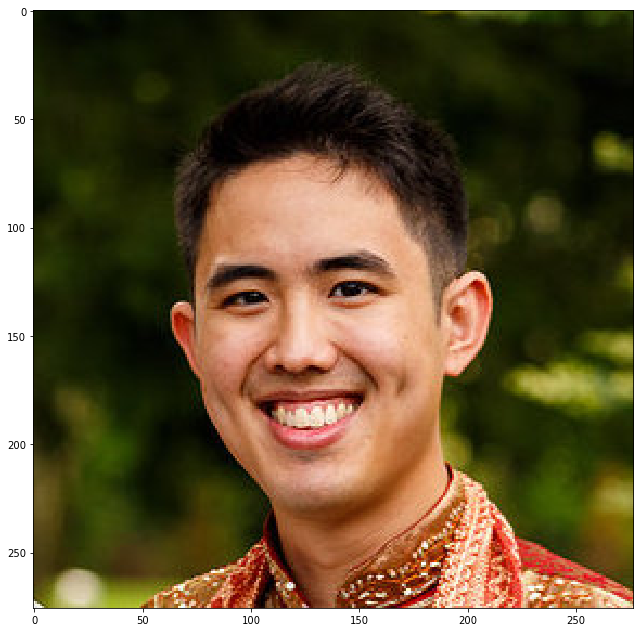

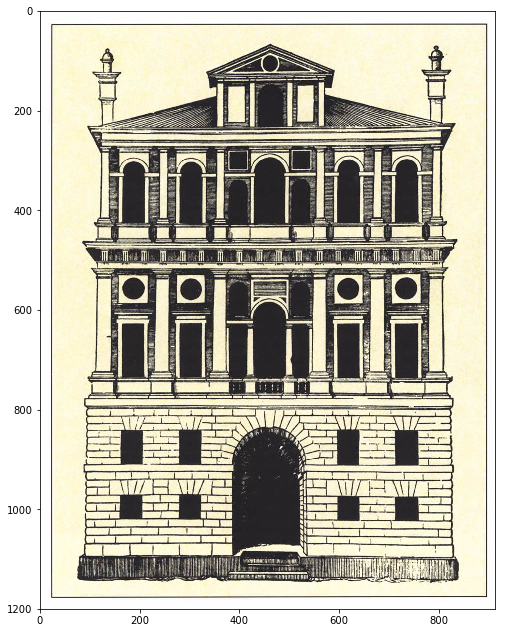

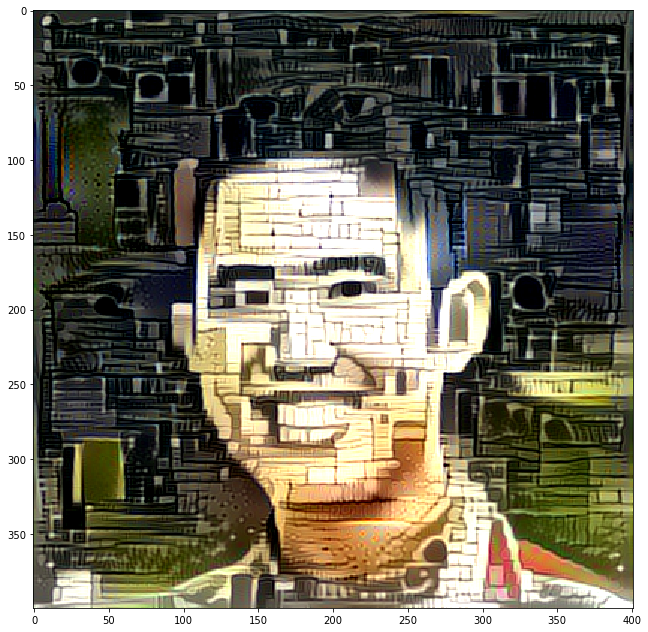

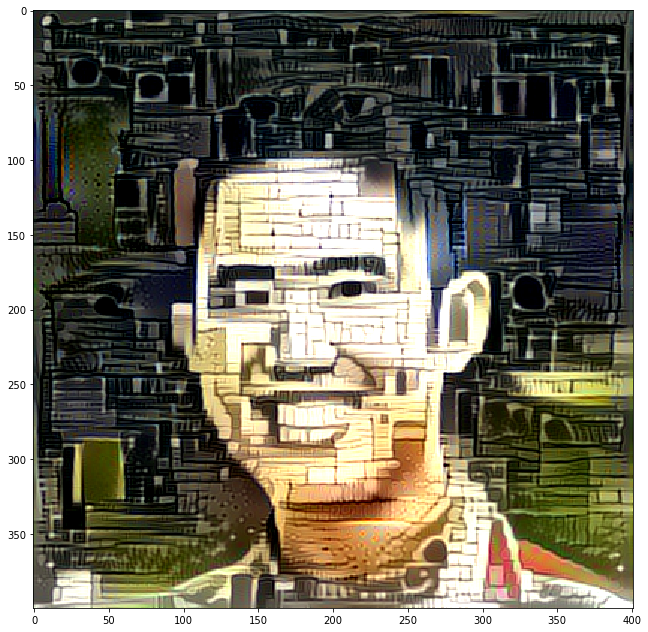

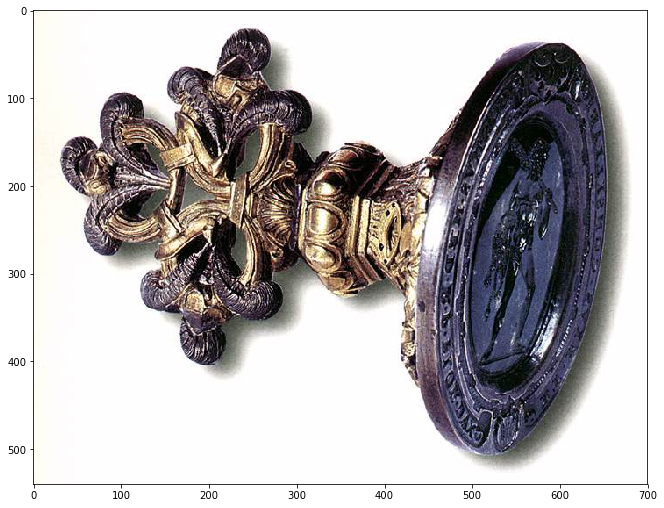

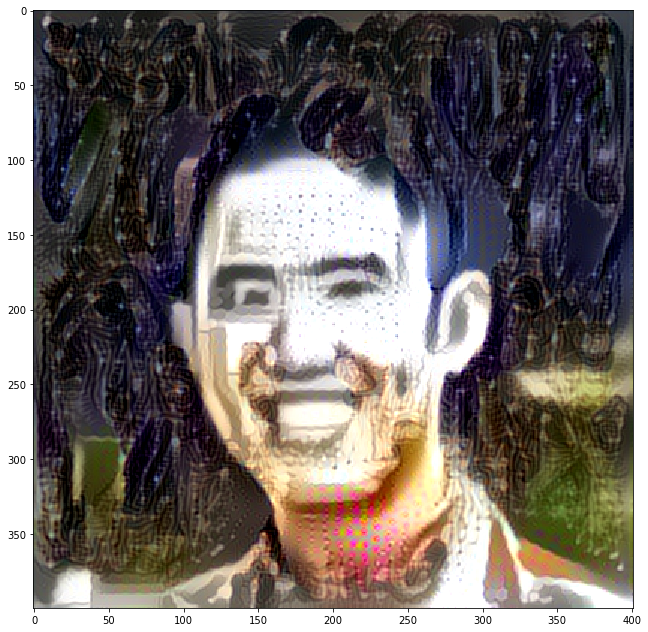

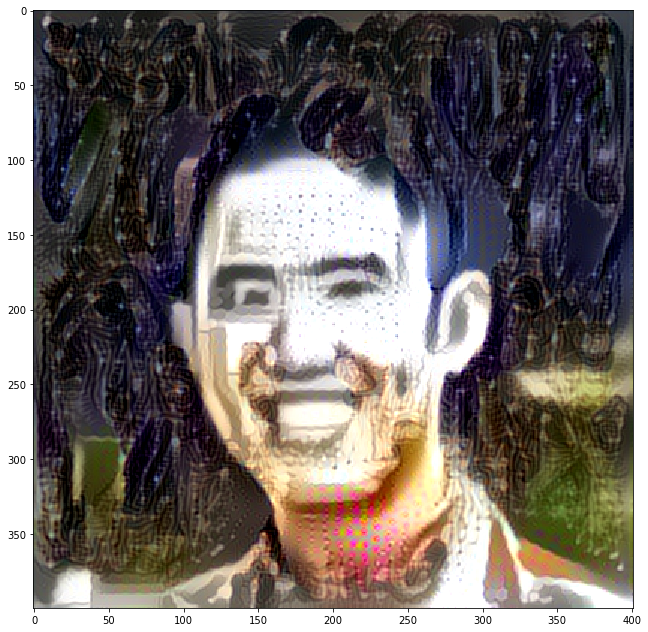

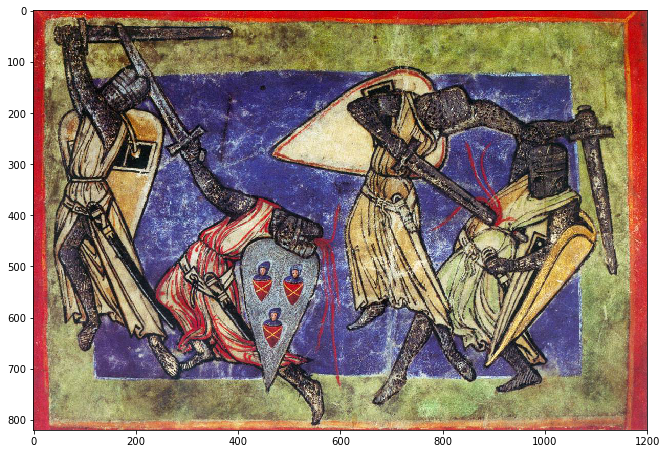

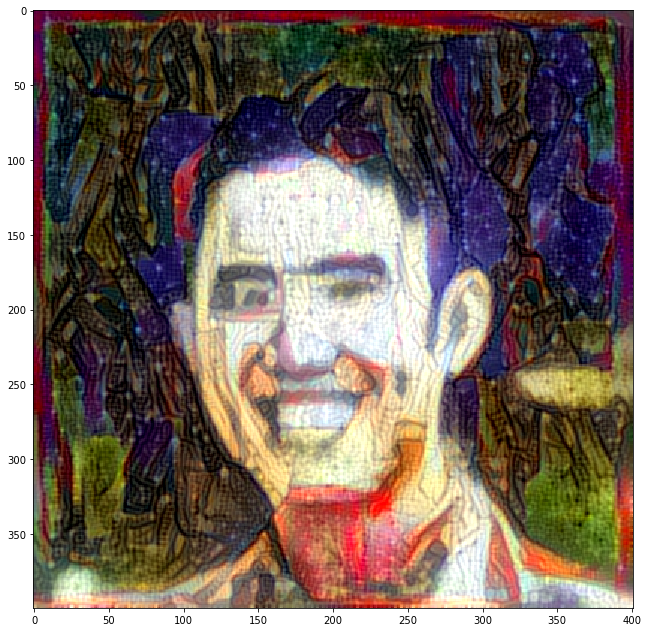

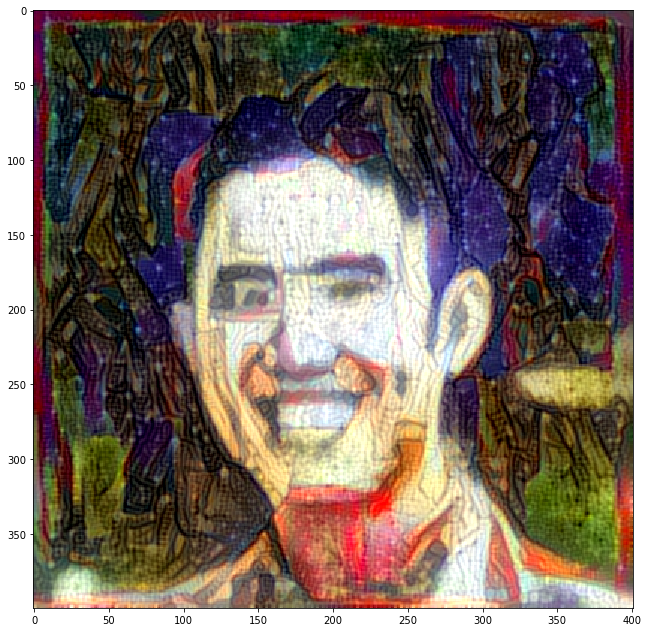

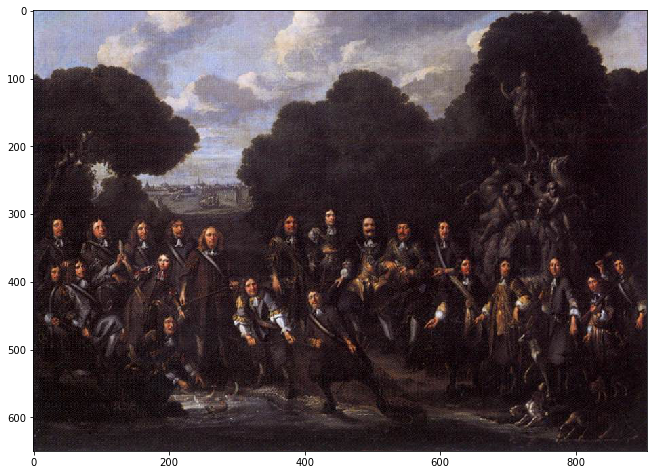

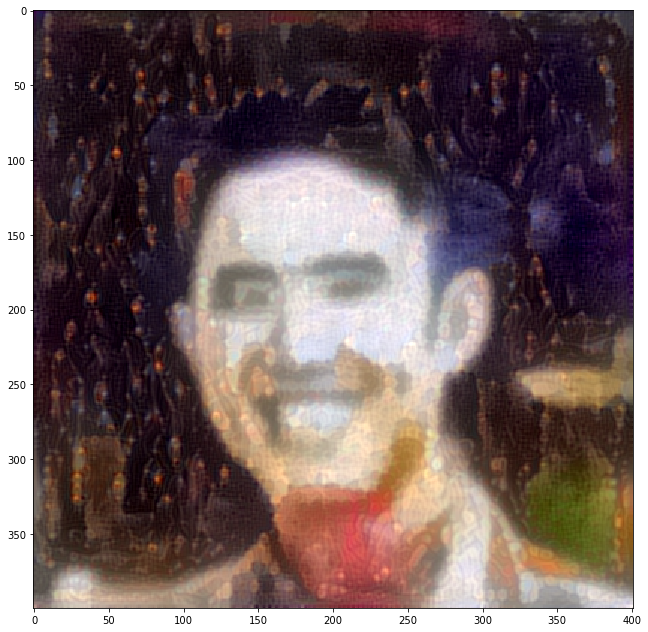

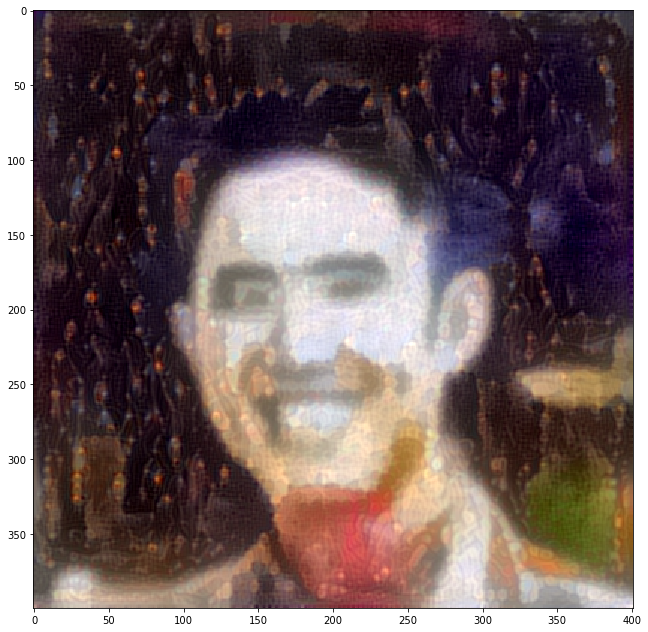

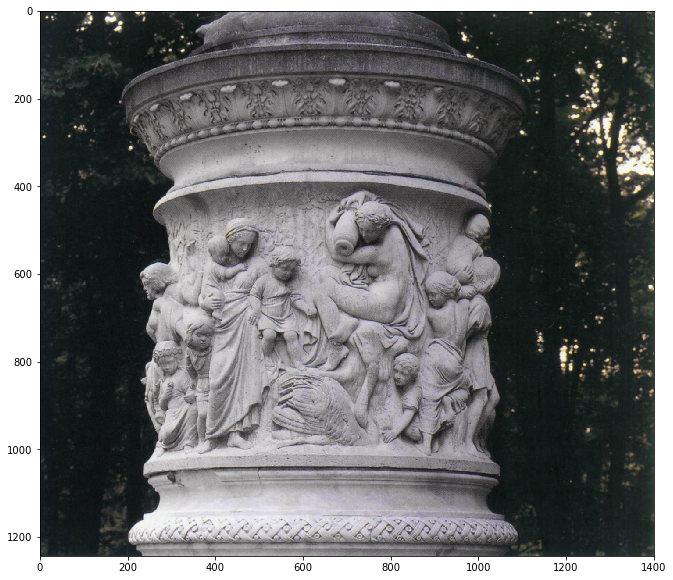

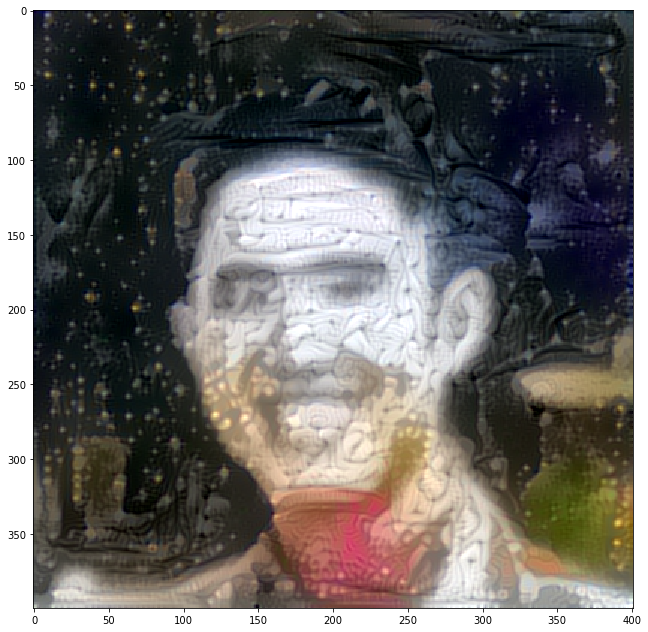

In [4]:
# Hyperparametercs
seed_image = 'me.jpg'
attribute = 'happy'
max_capital = 2


# Load image names and initialize the list of style images
with open(art_folder + 'image_mapping.txt', 'r') as file_handle:
    wga_names = file_handle.readlines()
wga_names = [name.split('\n')[0] for name in wga_names]
style_images = []

# Read the encoded features, then make a KDTree from them for matching
h5f = h5py.File(art_folder + 'features.h5', 'r')
encoded_features = h5f['encoded_features'][:]
h5f.close()
sys.setrecursionlimit(10000)  # So that we can actually build the tree
tree = spatial.KDTree(encoded_features)

# Figure out the domain for dragonfly to use
maxes = encoded_features.max(axis=0)
mins = encoded_features.min(axis=0)
domain = [(min_, max_) for min_, max_ in zip(mins, maxes)]


# Let's go!
current_image = copy.deepcopy(seed_image)
updates = 0
style_images = []
max_val, max_pt, history = maximise_function(lambda features: calc_attribute_match(features, attribute),
                                             domain, max_capital)

# Save it before we lose it!
seed_name = seed_image.split('.')[0]
with open('history_for_%s_%s.pkl' % (attribute, seed_name), 'wb') as file_handle:
    pickle.dump((max_val, history), file_handle)